# Starter cell 
## Run this cell first to enable working with this notebook

In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))




[1] bird_1
[bird_1] Loading data...
--- Dataset for bird_1 ---
File: bird_1_weight_report.csv.gz
Shape: (353027, 2)
Date range: 2025-06-10 11:36:55 → 2025-06-20 10:00:50
Weight range: 2.01g → 25.00g
Mode weight: 18.62 g
Median weight: 18.97 g


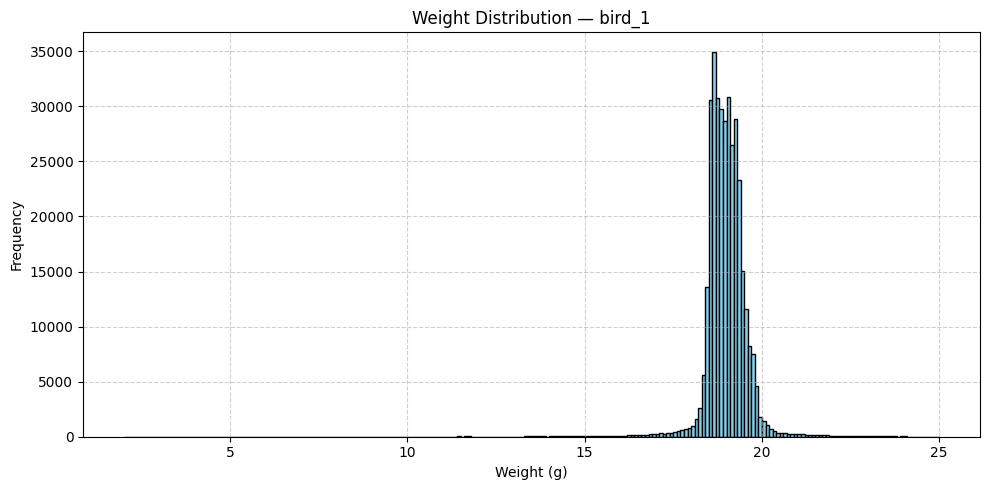


[2] bird_2
[bird_2] Loading data...
--- Dataset for bird_2 ---
File: bird_2_weight_report.csv.gz
Shape: (173082, 2)
Date range: 2025-06-10 17:26:45 → 2025-06-20 10:00:50
Weight range: 2.05g → 24.90g
Mode weight: 16.62 g
Median weight: 16.86 g


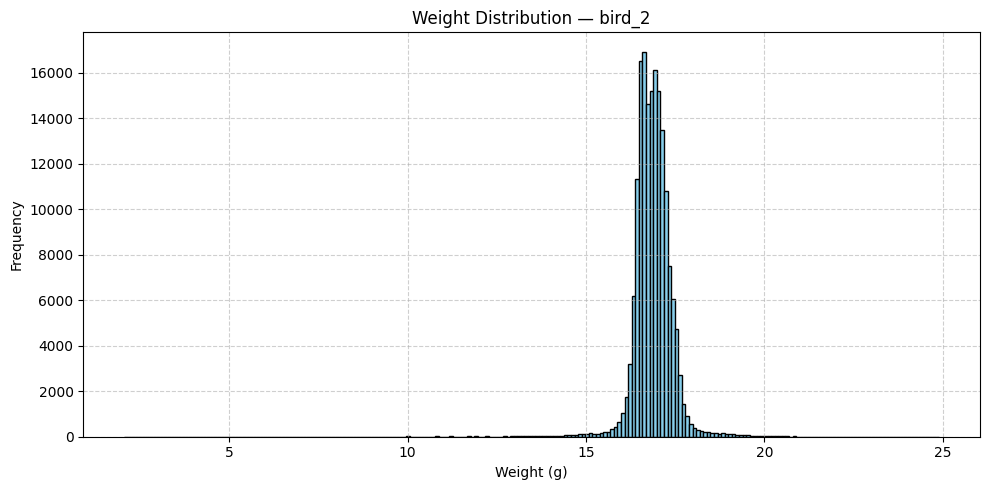


[3] bird_3
[bird_3] Loading data...
--- Dataset for bird_3 ---
File: bird_3_weight_report.csv.gz
Shape: (207709, 2)
Date range: 2025-06-10 13:18:36 → 2025-06-20 09:58:36
Weight range: 2.02g → 24.98g
Mode weight: 18.07 g
Median weight: 17.95 g


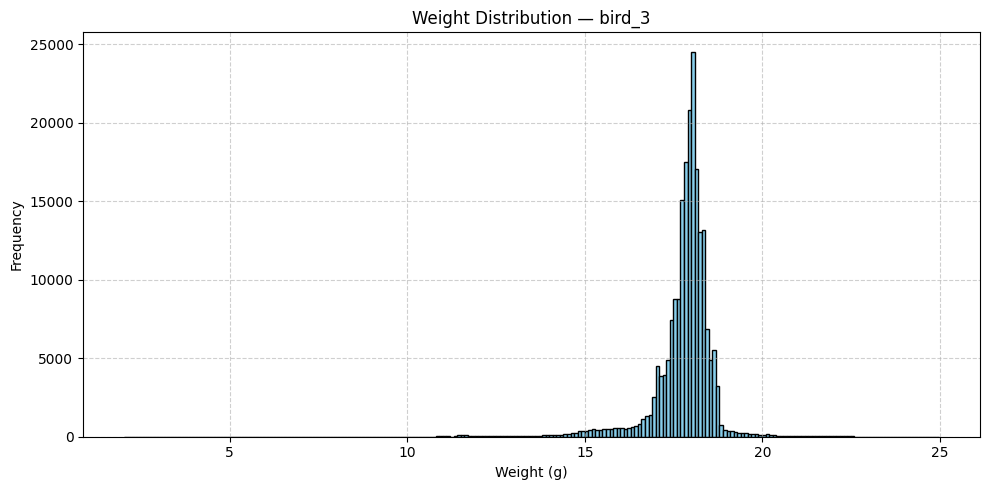


[4] bird_4
[bird_4] Loading data...
--- Dataset for bird_4 ---
File: bird_4_weight_report.csv.gz
Shape: (236317, 2)
Date range: 2025-06-10 12:24:18 → 2025-06-20 10:00:50
Weight range: 2.00g → 24.99g
Mode weight: 18.75 g
Median weight: 18.73 g


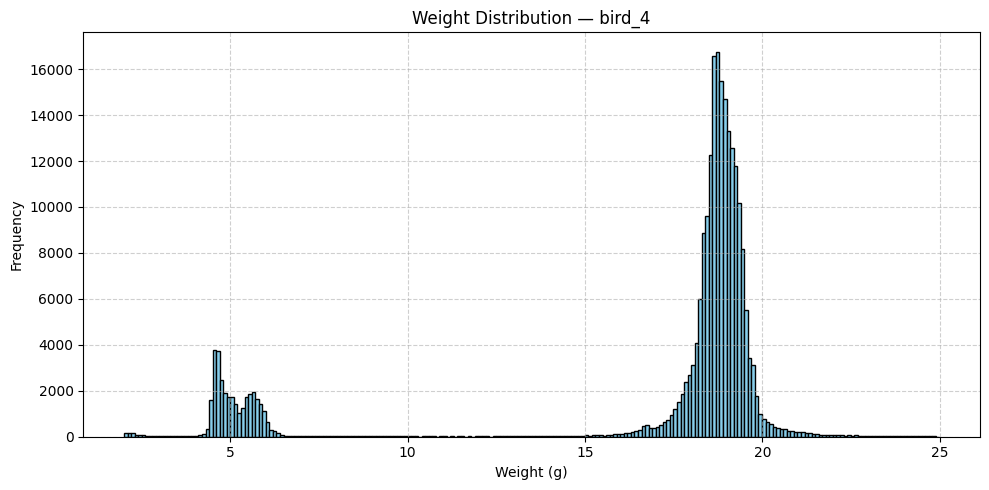


[5] bird_5
[bird_5] Loading data...
--- Dataset for bird_5 ---
File: bird_5_weight_report.csv.gz
Shape: (129075, 2)
Date range: 2025-06-10 12:18:25 → 2025-06-20 10:00:50
Weight range: 2.00g → 24.70g
Mode weight: 15.13 g
Median weight: 15.02 g


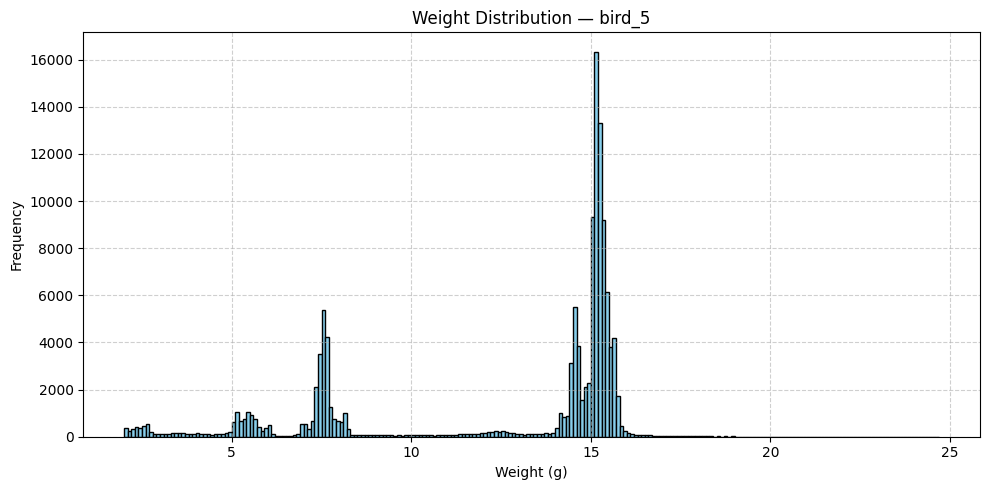


[6] bird_6
[bird_6] Loading data...
--- Dataset for bird_6 ---
File: bird_6_weight_report.csv.gz
Shape: (58702, 2)
Date range: 2025-06-12 14:08:35 → 2025-06-20 09:40:51
Weight range: 2.09g → 24.74g
Mode weight: 16.42 g
Median weight: 16.52 g


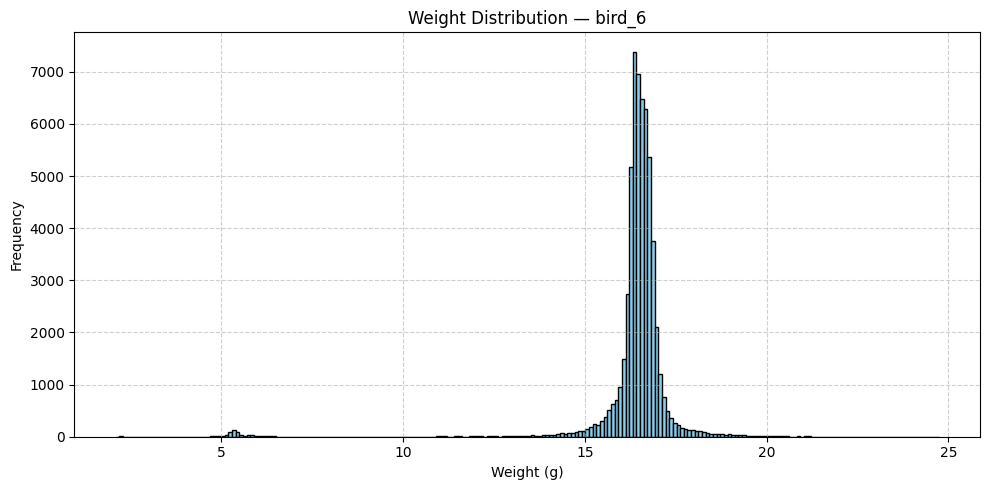


[7] bird_p1
[bird_p1] Loading data...
--- Dataset for bird_p1 ---
File: bird_p1_weight_report.csv.gz
Shape: (35597, 2)
Date range: 2024-07-03 08:14:02 → 2024-07-20 17:03:14
Weight range: 2.00g → 25.00g
Mode weight: 17.81 g
Median weight: 17.71 g


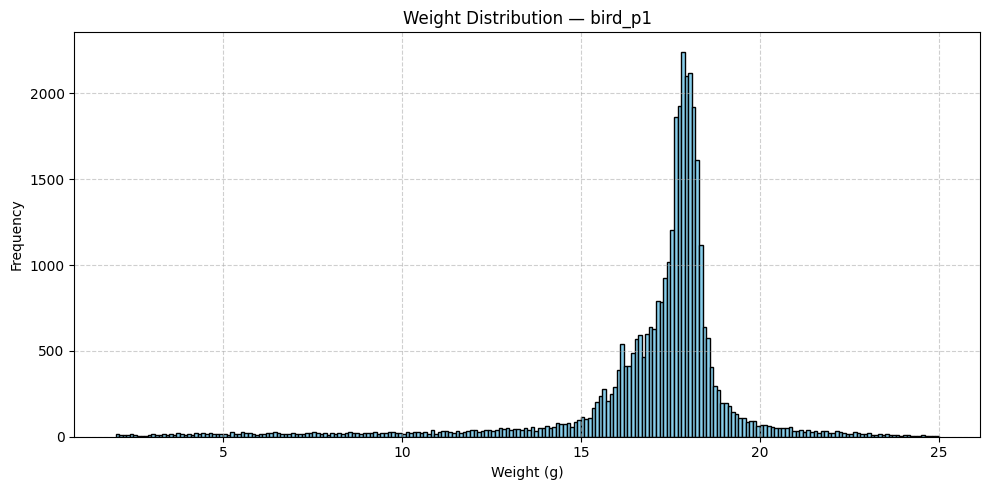


[8] bird_t1
[bird_t1] Loading data...
--- Dataset for bird_t1 ---
File: bird_t1_weight_report.csv.gz
Shape: (53750, 2)
Date range: 2024-07-02 18:34:23 → 2024-07-12 14:07:25
Weight range: 2.00g → 24.91g
Mode weight: 15.66 g
Median weight: 15.55 g


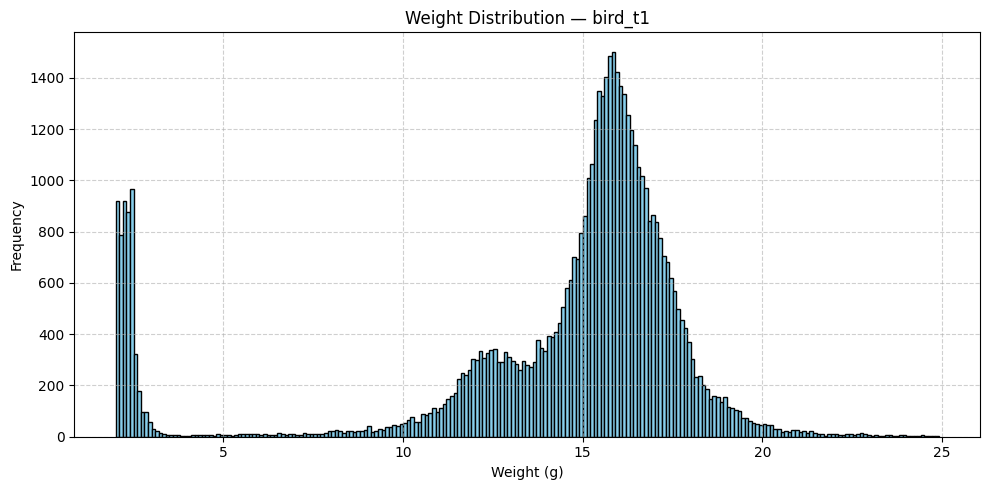

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from scripts._paths import BIRDS, META
from scripts.helpers import read_timeseries

def describe_bird_data(
    bird_id: str | int,
    start_date: str | None = None,
    end_date: str | None = None,
    *,
    low_thrd: float = 2,
    high_thrd: float = 25,
    binsize_g: float = 0.1,
    show_plot: bool = True,
):
    # build the filename: bird_X_weight_report.csv.gz
    print(f"[bird_{bird_id}] Loading data...")
    path = BIRDS / f"bird_{bird_id}_weight_report.csv.gz"

    df = read_timeseries(
        path,
        low_thrd=low_thrd,
        high_thrd=high_thrd,
        start_date=start_date,
        end_date=end_date,
    )

    if df.empty:
        print(f"[bird_{bird_id}] no data after filtering")
        return

    print(f"--- Dataset for bird_{bird_id} ---")
    print(f"File: {path.name}")
    print(f"Shape: {df.shape}")
    print(f"Date range: {df['Time'].min()} → {df['Time'].max()}")
    print(f"Weight range: {df['weight'].min():.2f}g → {df['weight'].max():.2f}g")

    # Mode and median
    mode_series = df["weight"].mode()
    mode_weight = float(mode_series.iloc[0]) if not mode_series.empty else float("nan")
    median_weight = float(df["weight"].median()) if not df["weight"].empty else float("nan")
    print(f"Mode weight: {mode_weight:.2f} g")
    print(f"Median weight: {median_weight:.2f} g")

    # Histogram
    if show_plot:
        w = df["weight"].dropna()
        bins = max(1, int(round((w.max() - w.min()) / binsize_g)))
        plt.figure(figsize=(10, 5))
        plt.hist(w, bins=bins, edgecolor="black", color="skyblue")
        plt.xlabel("Weight (g)")
        plt.ylabel("Frequency")
        plt.title(f"Weight Distribution — bird_{bird_id}")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()


# === Run over all bird files ===
for i, file in enumerate(sorted(BIRDS.glob("bird_*_weight_report.csv.gz")), 1):
    bird_id = file.stem.split("_")[1]  # extract the number from 'bird_X_weight_report'
    print(f"\n[{i}] bird_{bird_id}")
    describe_bird_data(bird_id, start_date=None, end_date=None)


# Part 2 - summary analysis

## Generate summary metrics of all bird data:

### This table calculates:
#### 1 - The MAE (mean absolute distance between each of the mode and stable estimates and the actual weight, per bird per day)
#### 2 - Pearson's r - correlation between each of the estimators and the true weight across all birds and all days, including p-value.

#### 3 - Other metrics such as Bias, R_squared, and % of true weight for the MAE (by how much the perch-scale deviates from the true weight values by average, in percentage of bodyweight)


#### * Filtered birds - the dataset after filtering out bird 2 as an outlier. (46 data points instead of 56)

# Part 2 - generate summary table of all birds with daily metrics

## Note that the save feature here is commented out as there is an existing summary report in the data/metadata.

In [5]:
from scripts.helpers import find_bird_file, compute_summary_metrics
import json

# Build a table across all birds and write to metadata/all_bird_summary.csv
weights_csv_path = P.META / "daily_manual_weights.csv"      # optional wide CSV of true weights

with open(P.META / "daily_manual_weights.json", 'r') as f:
    weights_dict = json.load(f)
rows = []
for bird_id in weights_dict.keys():
    if bird_id == 'start_date':
        continue
    try:
        fp = find_bird_file(bird_id, birds_dir=P.BIRDS)
    except FileNotFoundError:
        print(f"Skip {bird_id}: file not found.")
        continue

    s = compute_summary_metrics(
        bird_id, fp, weights_dict,
        low_thrd=1, high_thrd=35,
        win_size=10, step=10, weight_fraction=0.09,
        start_date='2025-06-11', end_date=None,
        tolerance_fraction=0.3, weights_csv_path=str(weights_csv_path),
        keep_out_of_range=True
    )
    if s is not None and not s.empty:
        rows.append(s)

all_summary = pd.concat(rows, axis=0, ignore_index=True) if rows else pd.DataFrame(
    columns=['date','stable_median','stable_mode','stable_mean','stable_std','stable_count','mode_estimate','true_weight','bird_id']
)

out_csv = P.META / "all_bird_summary.csv"
# out_csv.parent.mkdir(parents=True, exist_ok=True)
# all_summary.to_csv(out_csv, index=False)
display(all_summary)


,date,stable_median,stable_mode,stable_mean,stable_std,stable_count,mode_estimate,true_weight,bird_id
0,2025-06-11,18.8630,19.192,18.750039,0.365562,51,18.93,18.50,2
1,2025-06-12,16.5320,14.904,16.669068,0.814834,44,16.30,18.99,2
2,2025-06-13,15.2730,15.080,15.942963,1.253156,109,17.18,18.66,2
3,2025-06-14,17.2700,17.195,17.280922,0.259846,1465,17.27,18.49,2
4,2025-06-15,16.9280,16.831,16.926757,0.274718,1859,16.89,19.00,2
5,2025-06-16,17.2340,16.244,17.194675,0.529953,40,16.65,18.75,2
6,2025-06-17,16.9400,16.607,16.975408,0.412424,1985,16.66,18.47,2
7,2025-06-18,16.6130,16.570,16.635089,0.241987,4677,16.62,18.43,2
8,2025-06-19,17.0270,16.430,16.949116,0.389968,4955,17.10,18.48,2
9,2025-06-20,16.8440,16.862,16.805533,0.234651,1986,16.89,18.91,2


# Part 3 - Generate summary metrics using the 'all bird data' summary table:

## This code cell calculates:
### 1 - The MAE (mean absolute distance between each of the mode and stable estimates and the actual weight, per bird per day)
### 2 - Pearson's r - correlation between each of the estimators and the true weight across all birds and all days, including p-value.

### 3 - Other metrics such as Bias, R_squared, and % of true weight for the MAE (by how much the perch-scale deviates from the true weight values by average, in percentage of bodyweight)


### * Filtered_birds - the dataset after filtering out bird 2 as an outlier. (46 data points instead of 56)

In [6]:
# === Cell: Build accuracy metrics table on RAW scale ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scripts import _paths as P

def build_results_df_raw(
    summary_df: pd.DataFrame,
    estimators=("stable_mean", "mode_estimate"),
    filtered_bird: str = "2",
    single_bird: str | None = None,
) -> pd.DataFrame:
    """
    Compute accuracy metrics for raw-scale estimators vs. true_weight.

    Returns a DataFrame with columns:
    ['Dataset','Method','MAE (g)','MAE (% of true)','Bias (g)','R² (sklearn)','Pearson r','p-value']
    """
    required = {"true_weight", "bird_id", *estimators}
    missing = required - set(summary_df.columns)
    if missing:
        raise ValueError(f"summary_df missing required columns: {missing}")
    df_all = summary_df.dropna(subset=["true_weight", "bird_id"]).copy()
     # Ensure bird_id values are clean ints/strings for consistent filtering
    df_all["bird_id"] = df_all["bird_id"].apply(lambda x: str(int(x)) if pd.notna(x) else x)

    df_filtered = df_all[df_all["bird_id"] != str(filtered_bird)].copy()
    datasets = [("All_Birds", df_all), ("Filtered_Birds", df_filtered)]
    if single_bird is not None:
        ds_single = df_all[df_all["bird_id"] == str(single_bird)].copy()
        datasets.append(("Single_Bird", ds_single))
    rows = []
    for name, df in datasets:
        for method in estimators:
            sub = df.dropna(subset=[method, "true_weight"])
            if sub.empty:
                rows.append({
                    "Dataset": name, "Method": method,
                    "MAE (g)": np.nan, "MAE (% of true)": np.nan,
                    "Bias (g)": np.nan, "R² (sklearn)": np.nan,
                    "Pearson r": np.nan, "p-value": np.nan
                })
                continue

            y_true = sub["true_weight"].to_numpy(dtype=float)
            y_pred = sub[method].to_numpy(dtype=float)

            mae = mean_absolute_error(y_true, y_pred)
            bias = float(np.mean(y_pred - y_true))
            r2 = r2_score(y_true, y_pred)
            # Pearson r (guard against constant vectors)
            if np.std(y_true) == 0 or np.std(y_pred) == 0 or len(y_true) < 2:
                r, p = np.nan, np.nan
            else:
                r, p = pearsonr(y_pred, y_true)
            mae_percent = float(np.mean(np.abs((y_pred - y_true) / y_true)) * 100)

            rows.append({
                "Dataset": name, "Method": method,
                "MAE (g)": mae, "MAE (% of true)": mae_percent,
                "Bias (g)": bias, "R² (sklearn)": r2,
                "Pearson r": r, "p-value": p
            })

    return pd.DataFrame(rows)

# Example build:
summary_df = pd.read_csv(P.META / "all_birds_summary.csv")
results_df = build_results_df_raw(summary_df, estimators=("stable_mean","mode_estimate"), filtered_bird="2")

# # Save to csv
# results_df.to_csv(P.META / "accuracy_metrics.csv", index=False)
display(results_df)


,Dataset,Method,MAE (g),MAE (% of true),Bias (g),R² (sklearn),Pearson r,p-value
0,All_Birds,stable_mean,0.701438,3.849159,-0.368898,0.498010,0.789839,4.639952e-13
1,All_Birds,mode_estimate,0.709107,3.904374,-0.327679,0.518649,0.786294,6.938471e-13
2,Filtered_Birds,stable_mean,0.485078,2.714733,-0.090170,0.784929,0.900049,1.775974e-17
3,Filtered_Birds,mode_estimate,0.493261,2.776359,-0.047609,0.802240,0.903000,9.474169e-18
